In [49]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Building baseline with BERT

In [50]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# PATH CONSTANTS
ABSOLUTE_PATH = "/content/drive/My Drive/deepfake_tweets"
DATA_DIR_PATH = os.path.join(ABSOLUTE_PATH, "data/preprocessed/")

# MODEL CONSTANTS
MODEL_NAME = "bert-base-cased"
BATCH_SIZE = 32

In [51]:
# Import preprocessed dataset splits
train_set_path, val_set_path, test_set_path = (
    os.path.join(ABSOLUTE_PATH, "data/preprocessed/tweepfake_train.csv"),
    os.path.join(ABSOLUTE_PATH, "data/preprocessed/tweepfake_val.csv"),
    os.path.join(ABSOLUTE_PATH, "data/preprocessed/tweepfake_test.csv")
)

train_df, val_df, test_df = (
    pd.read_csv(train_set_path),
    pd.read_csv(val_set_path),
    pd.read_csv(test_set_path)
)

# Concatenate split sets into a single DataFrame
df = pd.concat([train_df, val_df, test_df], ignore_index=True)

## Defining the dataset loader

In [52]:
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

## Loading BERT tokenizer and model

In [53]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    # output_attentions=False,
    # output_hidden_states=False
)

model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Preparing dataset for testing

In [54]:
X_test = test_df['text_tokens'].values
y_test = (test_df['account.type'] == 'bot').astype(int).values

test_dataset = TweetDataset(X_test, y_test, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

## Model inference

In [55]:
def evaluate_model(model, dataloader):
  model.eval()
  predictions, true_labels = [], []

  with torch.no_grad():
    for batch in dataloader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      logits = outputs.logits

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = labels.to('cpu').numpy()

      # Get predictions
      preds = np.argmax(logits, axis=1)

      predictions.extend(preds)
      true_labels.extend(label_ids)

  return predictions, true_labels


predictions, true_labels = evaluate_model(model, test_dataloader)

### Evaluate results

In [56]:
accuracy = accuracy_score(true_labels, predictions)
print(f"Baseline Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=['Human', 'Bot']))

Baseline Accuracy: 0.5004

Classification Report:
              precision    recall  f1-score   support

       Human       0.00      0.00      0.00      1278
         Bot       0.50      1.00      0.67      1280

    accuracy                           0.50      2558
   macro avg       0.25      0.50      0.33      2558
weighted avg       0.25      0.50      0.33      2558



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


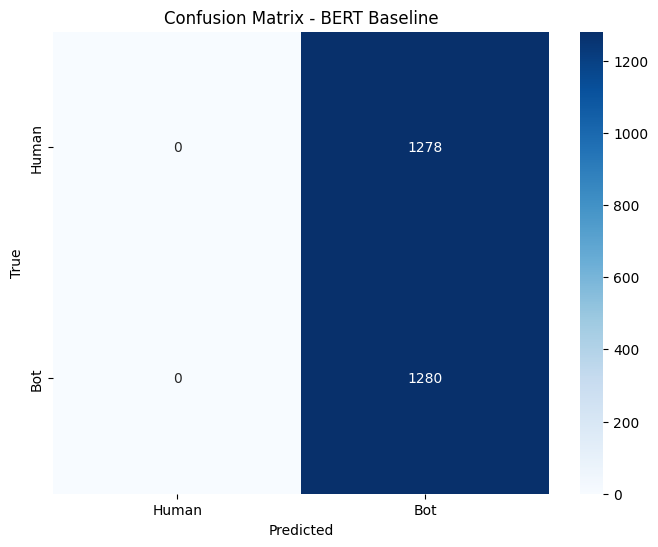

In [57]:
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'Bot'], yticklabels=['Human', 'Bot'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - BERT Baseline')
plt.show()